In [ ]:
import sys

# Ensure the correct Python kernel is selected
assert sys.version_info[:2] == (3, 10), "Please select the Python 3.10 kernel"

%pip install bitalino
%pip install matplotlib
%pip install numpy
%pip install pymongo
%pip install requests

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


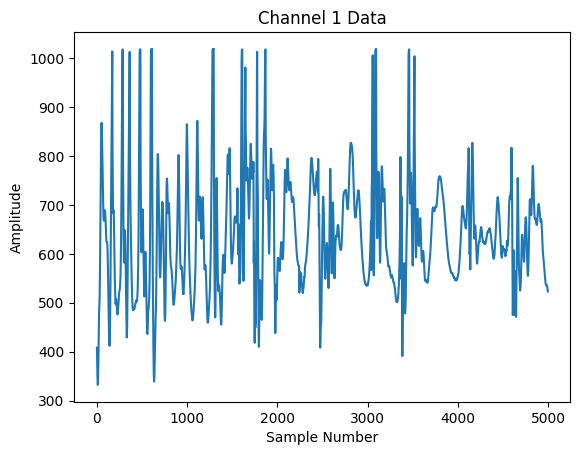

In [2]:
from bitalino import BITalino

# Adresse MAC de votre appareil BITalino
macAddress = "98:D3:51:FE:84:ED"

# Créer une instance de l'appareil BITalino
device = BITalino(macAddress)

# Démarrer l'acquisition de données
device.start(1000, [0, 1, 2, 3, 4]) # 1000 Hz, canaux 0 à 5

# Lire les données pendant 5 secondes
data = device.read(5000)

# Arrêter l'acquisition de données
device.stop()

# Fermer la connexion avec l'appareil
device.close()

import matplotlib.pyplot as plt

# Plot the data
# Les data sont stockées dans la case 5  du tableau pour le canal 1
channel_1_data = data[:, 8]

# Plot the data from channel 1
plt.plot(channel_1_data)
plt.title('Channel 1 Data')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
import threading
from bitalino import BITalino
from datetime import datetime
import requests
from pymongo import MongoClient
MAX_DATA_SEND_SAVE = 100000
# Adresse MAC de votre appareil BITalino
macAddress = "98:D3:51:FE:84:FC"


# Créer une instance de l'appareil BITalino
device = BITalino(macAddress)

# Démarrer l'acquisition de données
device.start(1000, [0, 1, 2, 3, 4,5])  # 1000 Hz, canaux 0 à 5

tab1 = []
tab2 = []
tab3 = []
tab4 = []
tab5 = []
tab6 = []
nb_data_send = 100

envoi = False

def collect_data():
    global tab1, tab2, tab3,tab4, tab5,tab6, envoi,nb_data_send
    try:
        i = 0
        while True:
            data = device.read(1)  # Lire 1 échantillon
            channel_1_data = data[0, 5]  # Extraire la valeur courante du canal 1
            channel_2_data = data[0, 6]  # Extraire la valeur courante du canal 2
            channel_3_data = data[0, 7]  # Extraire la valeur courante du canal 3
            channel_4_data = data[0, 8]  # Extraire la valeur courante du canal 4
            channel_5_data = data[0, 9]  # Extraire la valeur courante du canal 5
            channel_6_data = data[0, 10]  # Extraire la valeur courante du canal 6
            #print(f"Valeur courante du canal 1: {channel_1_data}")
            #print(f"Valeur courante du canal 2: {channel_2_data}")
            tab1.append({'temps': datetime.now().isoformat(timespec='milliseconds'), 'valeur': channel_1_data})
            tab2.append({'temps': datetime.now().isoformat(timespec='milliseconds'), 'valeur': channel_2_data})
            tab3.append({'temps': datetime.now().isoformat(timespec='milliseconds'), 'valeur': channel_3_data})
            tab4.append({'temps': datetime.now().isoformat(timespec='milliseconds'), 'valeur': channel_4_data})
            tab5.append({'temps': datetime.now().isoformat(timespec='milliseconds'), 'valeur': channel_5_data})
            tab6.append({'temps': datetime.now().isoformat(timespec='milliseconds'), 'valeur': channel_6_data})
            if i % nb_data_send == 0:
                envoi = True
            
    except KeyboardInterrupt:
        pass

def send_data():
    global tab1, tab2,tab3,tab4, tab5, envoi,nb_data_send
    while True:
        if len(tab1) >= nb_data_send and len(tab2) >= nb_data_send and len(tab3) >= nb_data_send and len(tab4) >= nb_data_send and len(tab5)>= nb_data_send and len(tab6) >= nb_data_send and envoi:
            # Préparer les données pour l'envoi
            data_to_send = []
            print("Envoi des données...")

            for entry in tab1[-nb_data_send*2:]:
                data_to_send.append({
                    'channel': 1,
                    'time': entry['temps'],
                    'valeur': int(entry['valeur'])
                })

            for entry in tab2[-nb_data_send*2:]:
                data_to_send.append({
                    'channel': 2,
                    'time': entry['temps'],
                    'valeur': int(entry['valeur'])
                })
                
            for entry in tab3[-nb_data_send*2:]:
                data_to_send.append({
                    'channel': 3,
                    'time': entry['temps'],
                    'valeur': int(entry['valeur'])
                })
            
            for entry in tab4[-nb_data_send*2:]:
                data_to_send.append({
                    'channel': 4,
                    'time': entry['temps'],
                    'valeur': int(entry['valeur'])
                    
                })
                
                
            for entry in tab5[-nb_data_send*2:]:
                data_to_send.append({
                    'channel': 5,
                    'time': entry['temps'],
                    'valeur': int(entry['valeur'])
                })
                
            for entry in tab6[-nb_data_send*2:]:
                data_to_send.append({
                    'channel': 6,
                    'time': entry['temps'],
                    'valeur': int(entry['valeur'])
                })

            # Convertir les données en JSON
            try:
                # Connexion à la base de données MongoDB
                client = MongoClient('mongodb://localhost:27017/')
                db = client['bitalino']
                collection = db['data']
                
                
                
                    
                    

                # Insérer les données dans la collection
                collection.insert_many(data_to_send)
                
                # Compter le nombre de documents dans la collection
                count = collection.count_documents({})
                if(count >= MAX_DATA_SEND_SAVE):
                    docs_to_delete = collection.find({}).sort("_id", 1).limit(count - MAX_DATA_SEND_SAVE)
                    ids_to_delete = [doc["_id"] for doc in docs_to_delete]
                    if ids_to_delete:
                        collection.delete_many({"_id": {"$in": ids_to_delete}})

                # Supprimer les données envoyées
                tab1 = tab1[nb_data_send:]
                tab2 = tab2[nb_data_send:]
                tab3 = tab3[nb_data_send:]
                tab4 = tab4[nb_data_send:]
                tab5 = tab5[nb_data_send:]
                envoi = False

                
            except requests.exceptions.RequestException as e:
                print(f"An error occurred: {e}")
                

# Créer et démarrer les threads
thread_collect = threading.Thread(target=collect_data)
thread_send = threading.Thread(target=send_data)

thread_collect.start()
thread_send.start()

# Attendre que les threads se terminent
thread_collect.join()
thread_send.join()


# Arrêter l'acquisition de données
device.stop()

# Fermer la connexion avec l'appareil
device.close()


Envoi des données...
Nombre de documents dans la collection: 103100
Envoi des données...
Nombre de documents dans la collection: 101200
Envoi des données...
Nombre de documents dans la collection: 101200
Envoi des données...
Nombre de documents dans la collection: 101200
Envoi des données...
Nombre de documents dans la collection: 101200
Envoi des données...
Nombre de documents dans la collection: 101200
Envoi des données...
Nombre de documents dans la collection: 101200
Envoi des données...
Nombre de documents dans la collection: 101200
Envoi des données...
Nombre de documents dans la collection: 101200
Envoi des données...
Nombre de documents dans la collection: 101200
Envoi des données...
Nombre de documents dans la collection: 101200
Envoi des données...
Nombre de documents dans la collection: 101200
Envoi des données...
Nombre de documents dans la collection: 101200
Envoi des données...
Nombre de documents dans la collection: 101200
Envoi des données...
Nombre de documents dans la

Fréquence cardiaque estimée : 491.70 BPM
Intervalle moyen entre pics : 122.03 ms
Écart-type des intervalles : 121.99 ms
Indice de variabilité : 0.9997


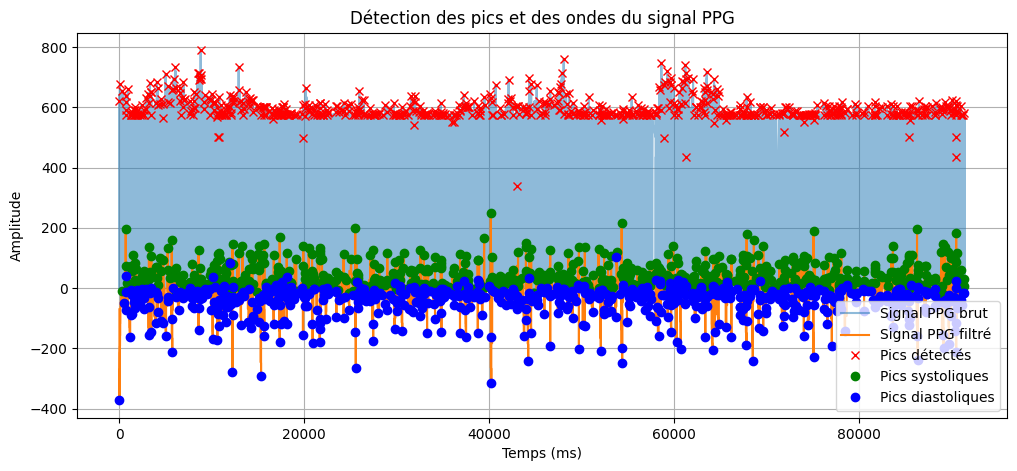

: 

In [ ]:
import json
import numpy as np
import pandas as pd
import scipy.signal as signal
import matplotlib.pyplot as plt
from pymongo import MongoClient

def load_ppg_data_from_mongo(mongo_uri, db_name, collection_name):
    client = MongoClient(mongo_uri)
    db = client[db_name]
    collection = db[collection_name]
    
    # Récupérer les données depuis MongoDB
    data = list(collection.find())
    df = pd.DataFrame(data)
    
    # Conversion du temps en datetime et tri
    df["time"] = pd.to_datetime(df["time"])
    df = df.sort_values(by="time")
    df["time_ms"] = (df["time"] - df["time"].iloc[0]).dt.total_seconds() * 1000
    return df

def calculate_bpm(df):
    time_ms = df["time_ms"].values
    signal_values = df["valeur"].values
    
    # Détection des pics
    peaks, _ = signal.find_peaks(signal_values, distance=200)
    
    # Calcul du BPM
    peak_intervals = np.diff(time_ms[peaks])
    bpm = 60000 / np.mean(peak_intervals) if len(peak_intervals) > 0 else None
    
    return bpm, time_ms, signal_values, peaks, peak_intervals

def analyze_signal_variability(peak_intervals):
    mean_interval = np.mean(peak_intervals)
    std_interval = np.std(peak_intervals)
    variability_index = std_interval / mean_interval if mean_interval != 0 else None
    return mean_interval, std_interval, variability_index

def detect_ppg_waves(signal_values, sampling_rate=1000):
    # Filtrage du signal pour mieux détecter les ondes
    b, a = signal.butter(3, [0.5, 5], btype='bandpass', fs=sampling_rate)
    filtered_signal = signal.filtfilt(b, a, signal_values)
    
    # Détection des ondes principales
    systolic_peaks, _ = signal.find_peaks(filtered_signal, distance=200)
    diastolic_peaks, _ = signal.find_peaks(-filtered_signal, distance=200)
    
    return filtered_signal, systolic_peaks, diastolic_peaks

def plot_ppg_signal(time_ms, signal_values, peaks, systolic_peaks, diastolic_peaks, filtered_signal):
    plt.figure(figsize=(12, 5))
    plt.plot(time_ms, signal_values, label="Signal PPG brut", alpha=0.5)
    plt.plot(time_ms, filtered_signal, label="Signal PPG filtré")
    plt.plot(time_ms[peaks], signal_values[peaks], "rx", label="Pics détectés")
    plt.plot(time_ms[systolic_peaks], filtered_signal[systolic_peaks], "go", label="Pics systoliques")
    plt.plot(time_ms[diastolic_peaks], filtered_signal[diastolic_peaks], "bo", label="Pics diastoliques")
    plt.xlabel("Temps (ms)")
    plt.ylabel("Amplitude")
    plt.title("Détection des pics et des ondes du signal PPG")
    plt.legend()
    plt.grid()
    plt.show()

if __name__ == "__main__":
    MONGO_URI = "mongodb://localhost:27017/"  # Modifier avec votre URI MongoDB
    DB_NAME = "bitalino"  # Nom de la base de données
    COLLECTION_NAME = "data"  # Nom de la collection
    
    df = load_ppg_data_from_mongo(MONGO_URI, DB_NAME, COLLECTION_NAME)
    bpm, time_ms, signal_values, peaks, peak_intervals = calculate_bpm(df)
    mean_interval, std_interval, variability_index = analyze_signal_variability(peak_intervals)
    filtered_signal, systolic_peaks, diastolic_peaks = detect_ppg_waves(signal_values)
    
    print(f"Fréquence cardiaque estimée : {bpm:.2f} BPM")
    print(f"Intervalle moyen entre pics : {mean_interval:.2f} ms")
    print(f"Écart-type des intervalles : {std_interval:.2f} ms")
    print(f"Indice de variabilité : {variability_index:.4f}")
    
    plot_ppg_signal(time_ms, signal_values, peaks, systolic_peaks, diastolic_peaks, filtered_signal)